## Satellite Image Classification using Neural Networks: Part1-Feature Engineering

### Step 1:  Importing the libraries

In [8]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from skimage import color
import mahotas as mt
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings("ignore")




### Step 2: Data Reading

In [2]:
train_data_path="deepsat-sat6/X_train_sat6.csv"
train_label_path="deepsat-sat6/y_train_sat6.csv"
test_data_path="deepsat-sat6/X_test_sat6.csv"
test_lable_path="deepsat-sat6/y_test_sat6.csv"

In [3]:
def data_read(data_path, nrows):
    data=pd.read_csv(data_path, header=None, nrows=nrows)
    data=data.values ## converting the data into numpy array
    return data


In [4]:
##Read training data
train_data=data_read(train_data_path, nrows=500)
print("Train data shape:" + str(train_data.shape))

##Read training data labels
train_data_label=data_read(train_label_path,nrows=500)
print("Train data label shape:" + str(train_data_label.shape))
print()

##Read test data
test_data=data_read(test_data_path, nrows=100)
print("Test data shape:" + str(test_data.shape))


##Read test data labels
test_data_label=data_read(test_lable_path,nrows=100)
print("Test data label shape:" + str(test_data_label.shape))



Train data shape:(500, 3136)
Train data label shape:(500, 6)

Test data shape:(100, 3136)
Test data label shape:(100, 6)


### Step 3: Data Visualization

In [5]:
#label converter
# [1,0,0,0,0,0]=building
# [0,1,0,0,0,0]=barren_land
# [0,0,1,0,0,0]=trees
# [0,0,0,1,0,0]=grassland
# [0,0,0,0,1,0]=road
# [0,0,0,0,0,1]=water


def label_conv(label_arr):
    labels=[]
    for i in range(len(label_arr)):
        
        if (label_arr[i]==[1,0,0,0,0,0]).all():
            labels.append("Building")  
            
        elif (label_arr[i]==[0,1,0,0,0,0]).all():  
            labels.append("Barren_land")  
            
        elif (label_arr[i]==[0,0,1,0,0,0]).all():
            labels.append("Tree") 
            
        elif (label_arr[i]==[0,0,0,1,0,0]).all():
            labels.append("Grassland")
            
        elif (label_arr[i]==[0,0,0,0,1,0]).all():
            labels.append("Road") 
            
        else:
            labels.append("Water")
    return labels
train_label_convert=label_conv(train_data_label)##train label conveter
test_label_convert=label_conv(test_data_label) ##test label converter


def data_visualization(data, label, n):
    ##data: training or test data
    ##lable: training or test labels
    ## n: number of data point, it should be less than or equal to no. of data points
    fig = plt.figure(figsize=(14, 14))
    ax = []  # ax enables access to manipulate each of subplots
    rows, columns=4,4
    for i in range(columns*rows):
        index=np.random.randint(1,n)
        img= data[index].reshape([28,28,4])[:,:,:3] ##reshape input data to rgb image
        ax.append( fig.add_subplot(rows, columns, i+1) ) # create subplot and append to ax
        ax[-1].set_title("Class:"+str(label[index]))  # set class
        plt.axis("off")
        plt.imshow(img)

    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    plt.show()  # finally, render the plot

.

### Step 3.1: Training data visualization

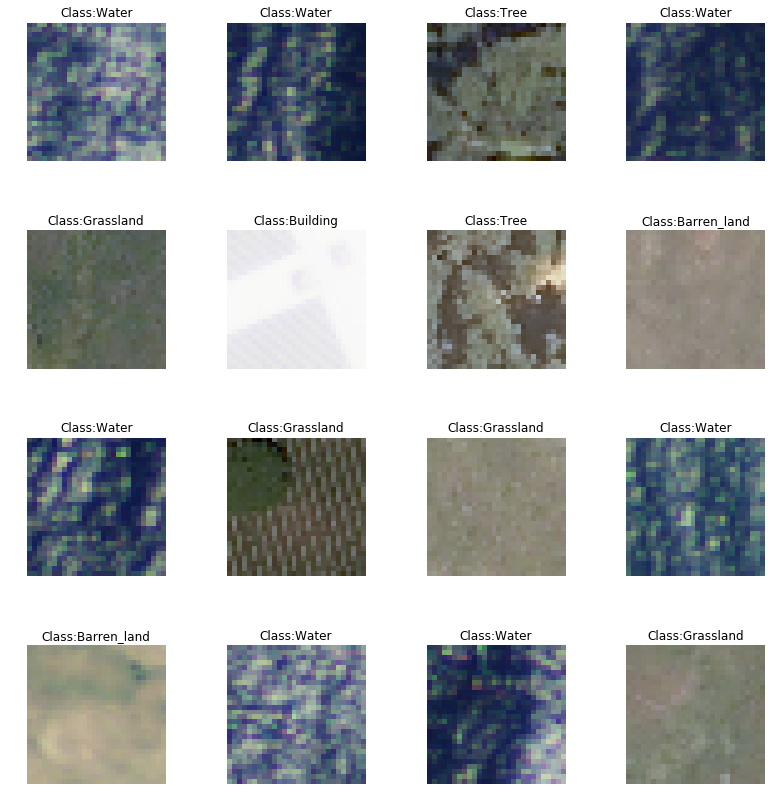

In [6]:
data_visualization(train_data,train_label_convert, n=500)

.

### Step 3.1: Test data visualization

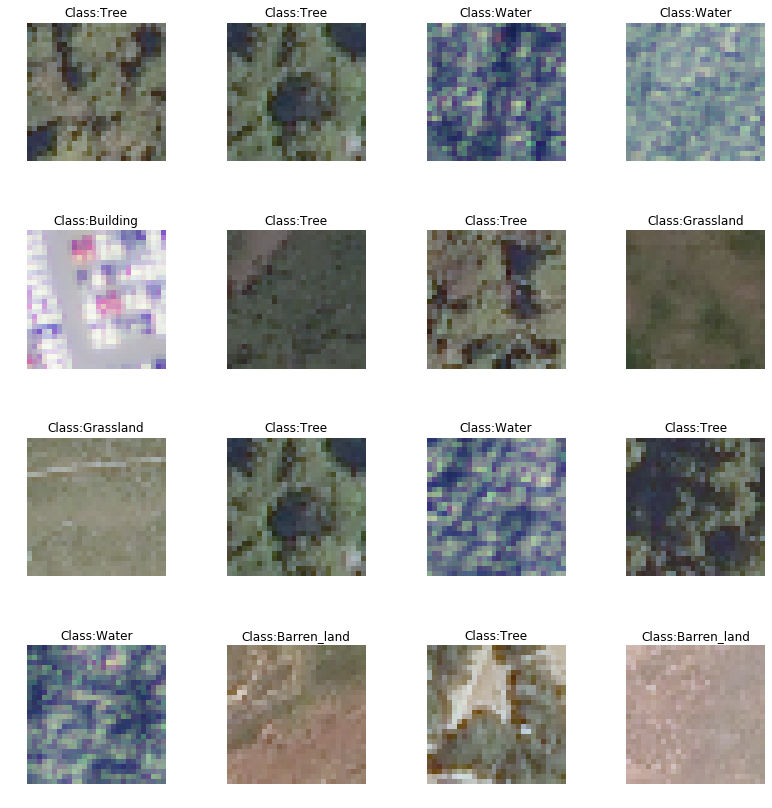

In [7]:
data_visualization(test_data,test_label_convert, n=100)

## Step 4: Feature Extraction 

In [25]:

#  texture_features=["Angular Second Moment","Contrast","Correlation","Sum of Squares: Variance","Inverse Difference Moment",
#                    "Sum Average","Sum Variance","Sum Entropy","Entropy","Difference Variance","Difference Entropy",
#                    "Information Measure of Correlation 1","Information Measure of Correlation 2""Maximal Correlation Coefficient"]

#https://gogul09.github.io/software/texture-recognition #references for texture feature calculations

def feature_extractor(input_image_file):
    
        tex_feature=[]
        hsv_feature=[]
        ndvi_feature=[]
        arvi_feature=[]

        for df_chunk in pd.read_csv(input_image_file ,header=None,chunksize = 5000):

            df_chunk=df_chunk.astype("int32")
            data=df_chunk.values


            ################data for HSV and Texture feature##############
            img=data.reshape(-1,28,28,4)[:,:,:,:3]
            #############################################################

            ######################Data for NDVI and ARVI#################

            NIR=data.reshape(-1,28,28,4)[:,:,:,3]
            Red=data.reshape(-1,28,28,4)[:,:,:,2]
            Blue=data.reshape(-1,28,28,4)[:,:,:,0]
            #############################################################

            for i in range(len(data)):

                #######Texture_feature####################################
                textures = mt.features.haralick(img[i])
                ht_mean= textures.mean(axis=0)
                tex_feature.append(ht_mean)
                ##########################################################

                #######hsv_feature#########################################
                img_hsv = color.rgb2hsv(img[i]) # Image into HSV colorspace
                h = img_hsv[:,:,0] # Hue
                s = img_hsv[:,:,1] # Saturation
                v = img_hsv[:,:,2] # Value aka Lightness
                hsv_feature.append((h.mean(),s.mean(),v.mean()))
                ###########################################################

                ##########Calculation of NDVI Feature######################
                NDVI=(NIR[i]-Red[i])/(NIR[i]+Red[i])
                ndvi_feature.append(NDVI.mean())
                ############################################################

                ###################Calculation of ARVI#####################
                a_1=NIR[i] -(2*Red[i]-Blue[i])
                a_2=NIR[i] +(2*Red[i]+Blue[i])
                arvi=a_1/a_2
                arvi_feature.append(arvi.mean())
                #######################################################

        features=[]
        for i in range(len(tex_feature)):
            h_stack=np.hstack((tex_feature[i], hsv_feature[i], ndvi_feature[i], arvi_feature[i]))
            features.append(h_stack)
            
        return features

### Features extraction from training data

In [27]:
train_data_features=feature_extractor(train_data_path)
# saving train data features
feature=pd.DataFrame(train_data_features, columns=["feature"+ str(i) for i in range(len(train_data_features[0]))])
feature.to_csv("train_feature_deepstat_6.csv")

### Features extraction from test data

In [28]:
#test data features extraction
test_data_features=feature_extractor(test_data_path)
feature_test=pd.DataFrame(test_data_features, columns=["feature"+ str(i) for i in range(len(train_data_features[0]))])
feature_test.to_csv("test_feature_deepsat_6.csv")